Load some libraries we will use:

In [108]:
#from itertools import product
import numpy as np
from scipy import optimize
from scipy import interpolate
import sympy as sm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('seaborn-whitegrid')
import seaborn as sns

<br>

# AS-AD model: Small open economy

The following exercise asks you to analyze a small open economy with fixed exchange rates. It is similar to the first exercise that studied a closed economy, but asks you to do more by yourselves. It might be useful to consult the solutions to the first exercise to guide you. 

Consider the following open economy AS-AD model. 

The short-run supply curve (SRAS) is given by
$$
\pi_{t} = \pi^{f} + \gamma (y_{t}-\bar{y}) + s_{t}
$$
where $s_t$ is a supply shock. 

The AD curve under fixed exchange rates is given by 
$$
y_{t}-\bar{y} = \beta_1(e^r_{-1}-\pi_t+\pi^f)+z_t
$$
where $z_t$ captures demand shocks (foreign real interest rates, public spending, confidence or taxes). 

The real exchange rate evolves as
$$
e^{r} = e_{-1}^r+\pi^f-\pi
$$


Assume that both the demand and the supply disturbances are AR(1) processes

$$ 
\begin{aligned}
z_{t} &= \delta z_{t-1} + x_{t} \\
s_{t} &= \omega s_{t-1} + c_{t} 
\end{aligned}
$$

where $x_{t}$ is a demand shock, and $c_t$ is a supply shock.

Assume that $x_t$ and $c_t$ are  normally distributed

$$ 
\begin{aligned}
x_{t}&\sim\mathcal{N}(0,\sigma_{x}^{2}) \\
c_{t}&\sim\mathcal{N}(0,\sigma_{c}^{2}) \\
\end{aligned}
$$

<br>

## 1. Define parameters (10%)
Set the parameters of the model and save them in a dictionary called par. Justify the value you set for each parameter.

In [109]:
par = {}

par['beta1'] = 0.5 # Sensitivity of output gap to real exchange rate gap; moderate value
par['gamma'] = 0.5 # Slope of SRAS; moderate price rigidity
par['pif'] = 0.02 # Inflation target (2% per year)
par['ybar'] = 0.0 # Natural output gap (zero)

In [110]:
# suppose the shock processes are parameterized as follows: 
par['delta'] = 0.8 # annual persistence demand shock
par['omega'] = 0.15 # annual persistence supply shock
par['sigma_x'] = 1.5 # variance demand shock
par['sigma_c'] = 0.2 # variance supply shock

<br>

## 2. Solve for the equilibrium

Next, we use the ``SymPy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, given the parameters, the lagged real exchange rate $e_{-1}^r$ and the contamporaneous shocks. The equilibrium is defined by the point where AD = SRAS. 

Use the first hand-in assignment as a guide for how to do this.

<br>
Solve the AD curve for inflation:

$$
\begin{aligned}
y_{t}-\bar{y} = \beta_1(e^r_{-1}-\pi_t+\pi^f)+z_t \\
\iff \pi_t = \pi^f +e^r_{t-1} -\frac{1}{\beta_1}(y_t-\bar{y}-z_t) 
\end{aligned}
$$

No work needed for the SRAS curve: 
$\pi_{t} = \pi^f + \gamma (y_{t}-\bar{y}) + s_{t} $

In [111]:
# your code here
y, pi, er_lag, z, s = sm.symbols('y pi er_lag z s')

beta1_sym, gamma_sym, pif_sym, ybar_sym = sm.symbols('beta1 gamma pif ybar')

beta1 = par['beta1']
gamma = par['gamma']
pif = par['pif']
ybar = par['ybar']

In [112]:
AD = pif + er_lag - (1/beta1)*(y - ybar - z)
AD = pif_sym + er_lag - (1/beta1_sym)*(y - ybar_sym - z)


In [113]:
SRAS = pif + gamma*(y - ybar) + s

SRAS = pif_sym + gamma_sym*(y - ybar_sym) + s

<br>
Now, find the solution for output by equating AS and AD using ``SymPy``'s ``solve`` and ``Eq`` methods. 

To find the solution for inflation, evaluate either the AD or AS curve at the equilibrium output value we just found using the ``subs`` method.

In [114]:
y_eq = sm.solve(sm.Eq(AD,SRAS),y)[0]
y_eq

(beta1*er_lag + beta1*gamma*ybar - beta1*s + ybar + z)/(beta1*gamma + 1)

In [115]:
pi_eq = AD.subs(y,y_eq)
pi_eq

er_lag + pif - (-ybar - z + (beta1*er_lag + beta1*gamma*ybar - beta1*s + ybar + z)/(beta1*gamma + 1))/beta1

<br>

## 3. Illustrate the equilibrium (20%)
Plot the AS and AD curves and the equilibrium in $(y,\pi)$-space). Do this for the following four periods: $z_{0} = 0, z_1=0.1,z_2=0,z_3=0$, that is, for a temporary positive demand shock. Assume we start at the long run equilibrium with $e^r_{-1}=0$ and that there are no supply shocks, $s_t=0,\forall t$. Explain the adjustment in the economy. 

First, convert the SymPy functions to NumPy functions that can be evaluated quickly numerically using lambdify:

In [116]:
# complete the code below

par_syms = {
    beta1_sym: par['beta1'],
    gamma_sym: par['gamma'],
    pif_sym: par['pif'],
    ybar_sym: par['ybar']
}

AD_final_expr = AD.subs(par_syms)
SRAS_final_expr = SRAS.subs(par_syms)
y_eq_final_expr = y_eq.subs(par_syms)
pi_eq_final_expr = pi_eq.subs(par_syms)


AD_func   = sm.lambdify((y, er_lag, z), AD_final_expr)
SRAS_func = sm.lambdify((y, s), SRAS_final_expr)

y_eq_func  = sm.lambdify((er_lag, z, s), y_eq_final_expr)
pi_eq_func = sm.lambdify((er_lag, z, s), pi_eq_final_expr)



Now plot the figure: Construct a grid for output and plot both AD as a function of y (four curves, for the four different values of the shock) and AS as a function of y. Note that the real exchange rate is not plotted, but does change from one period to the next, which affects the position of the AD curve!

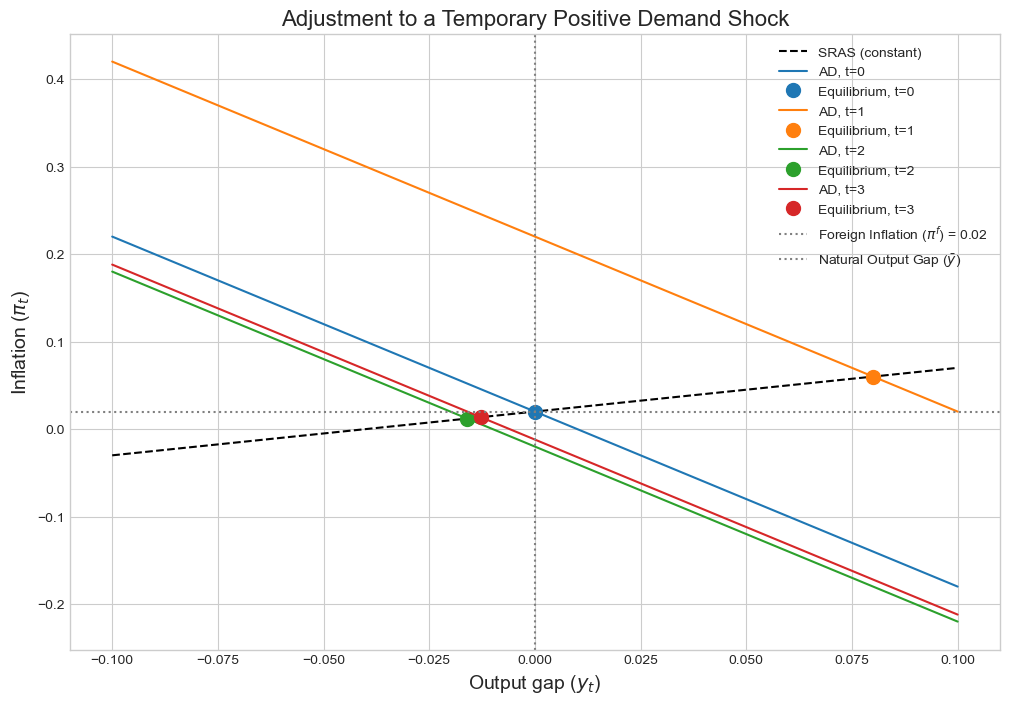

In [117]:
# your code here


z_seq = [0, 0.1, 0, 0] # Temporary positive demand shock
s_t = 0 # No supply shocks
er_lag_t0 = 0 # Start at long-run equilibrium (e_r = 0 implies competitiveness is at baseline)

# Create a grid for the output gap (y) to plot the curves
ys = np.linspace(-0.1, 0.1, 100) 

# Setup the plot
plt.figure(figsize=(12,8))

# Plot the SRAS curve (it does not shift as s_t=0)
SRAS_vals = [SRAS_func(y, s_t) for y in ys]
plt.plot(ys, SRAS_vals, 'k--', label='SRAS (constant)')

# Initialize er_lag for the loop
er_lag = er_lag_t0

# Loop through the four periods
for t, z_t in enumerate(z_seq):
    # Calculate the AD curve for the current period
    AD_vals = [AD_func(y, er_lag, z_t) for y in ys]
    ad_plot = plt.plot(ys, AD_vals, label=f'AD, t={t}')
    
    # Calculate and plot the equilibrium point for the current period
    y_star = y_eq_func(er_lag, z_t, s_t)
    pi_star = pi_eq_func(er_lag, z_t, s_t)
    plt.plot(y_star, pi_star, 'o', markersize=10, color=ad_plot[0].get_color(), label=f'Equilibrium, t={t}')
    
    # Update the lagged real exchange rate for the next period using: e_r(t) = e_r(t-1) + pi_f - pi(t)
    # This e_r(t) will be the er_lag for period t+1
    er_lag = er_lag + par['pif'] - pi_star

# Add plot details for clarity
plt.xlabel('Output gap ($y_t$)', fontsize=14)
plt.ylabel('Inflation ($\pi_t$)', fontsize=14)
plt.title('Adjustment to a Temporary Positive Demand Shock', fontsize=16)
plt.axhline(par['pif'], color='grey', linestyle=':', label=f"Foreign Inflation ($\pi^f$) = {par['pif']}")
plt.axvline(0, color='grey', linestyle=':', label='Natural Output Gap ($\\bar{y}$)')
plt.legend()
plt.grid(True)
plt.show()

[Your explanation here]

The plot illustrates the economy's dynamic response to a temporary positive demand shock under a fixed exchange rate regime.

* **Period 0 (t=0):** The economy starts in a long-run equilibrium where the output gap is zero ($y_0=0$) and domestic inflation equals foreign inflation ($\pi_0 = \pi^f$). The initial AD curve (AD, t=0) intersects the SRAS curve at this point. The real exchange rate is stable.

* **Period 1 (t=1):** A positive demand shock ($z_1=0.1$) hits the economy. This shifts the **AD curve to the right** (to AD, t=1). The economy moves along the upward-sloping SRAS curve to a new short-run equilibrium (Equilibrium, t=1). Both the **output gap and inflation rise** ($y_1 > 0$ and $\pi_1 > \pi^f$). Because domestic inflation now exceeds foreign inflation, the **real exchange rate begins to appreciate** (it becomes less competitive), as domestic goods become relatively more expensive.

* **Period 2 (t=2):** The temporary demand shock disappears ($z_2=0$). However, the economy does not immediately return to the initial equilibrium. The real exchange rate appreciation from the previous period has made domestic goods more expensive, reducing net exports. This loss of competitiveness acts like a negative demand shock, shifting the **AD curve to the left** of its original position (see AD, t=2). The economy now experiences a **recession**, with the output gap turning negative ($y_2 < 0$) and inflation falling below the foreign inflation rate ($\pi_2 < \pi^f$).

* **Period 3 (t=3) and beyond:** In period 2, inflation was below the foreign rate, which causes the real exchange rate to start depreciating (moving back towards its initial level). This depreciation makes domestic goods more competitive again, slightly increasing net exports. Consequently, the **AD curve shifts back to the right** (AD, t=3) compared to its position in period 2. The output gap and inflation start moving back towards the long-run equilibrium. This process of adjustment continues over subsequent periods, with the AD curve gradually shifting back to its initial position as the real exchange rate returns to its long-run level and inflation converges back to the foreign inflation rate.
"""

<br>

## 4. Impulse responses (30%)
We will now construct impulse responses to answer the following question: *Starting from the long-run equilibrium, how does the economy evolve in response to a one-time, one standard-deviation demand shock?* 

The starting point of the economy is $e^r_{-1} = 0$. 
The shock sequence we are considering is: $x_0 = \sigma_x$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$.

*Step 1*
Define two functions that we will reuse later:
1. allocate memories and draw random shocks given parameters and the number of time periods we want to simulate
2. simulate the economy given the shock sequences from 1. 

*Step 2*
Run the simulations.

*Step 3*
Illustrate the results in two ways: 
1. in $(y,\pi)$-space, and 
2. plotting $y,\pi$ and $e^r$ as a function of periods since the shock. 

*Step 4*
1. Explain the economics of your results. In particular: 
2. Are output gap and inflation perfectly (negatively or positively?) correlated? Why (not)? How does this compare to the closed economy model?
3. Will we always get a recession at some point after a positive demand shock? Why (not)? How does this compare to the closed economy model?

<br>

**Step 1**:
Define function prep_sim to **allocate memory and draw random shocks**

In [118]:
def prep_sim(par,T,seed=1986):
    """ prepare simulation
    
    Args:
    
        par (dict): model parameters
        T (int): number of periods to simulate
        seed (int,optional): seed for random numbers
        
    Returns:
    
        sim (dict): container for simulation results
        
    """
    
    # a. set seed
    if not seed == None:
        np.random.seed(seed)
    
    # b. allocate memory
    sim = {}
    sim['y'] = np.zeros(T)
    sim['pi'] = np.zeros(T)
    sim['er'] = np.zeros(T)
    sim['z'] = np.zeros(T)
    sim['s'] = np.zeros(T)
    
    # c. draw random shocks
    sim['x_raw'] = np.random.normal(loc=0,scale=1,size=T)
    sim['c_raw'] = np.random.normal(loc=0,scale=1,size=T)
    
    return sim

**Step 1 (continued)**:
Define function **simulate** to run the simulations

In [119]:
# complete the code below

def simulate(par,sim,T):
    """ run simulation
    
    Args:
    
        par (dict): model parameters
        sim (dict): container for simulation results        
        T (int): number of periods to simulate
                
    """
    
    for t in range(1,T):

        er_lag = sim['er'][t-1]
        
        # a. shocks
        sim['z'][t] = par['delta']*sim ['z'][t-1] + par['sigma_x']*sim['x_raw'][t]
        sim['s'][t] = par['omega']*sim ['s'][t-1] + par['sigma_c']*sim['c_raw'][t]

        # b. output
        sim['y'][t] = y_eq_func(er_lag, sim['z'][t], sim['s'][t])
        
        # c. inflation
        sim['pi'][t] = pi_eq_func(er_lag, sim['z'][t], sim['s'][t])
        
        # d. real exchange rate
        sim['er'][t] = er_lag + par['pif'] - sim['pi'][t]

<br>

**Step 2:** Run the simulations

In [120]:
# your code here

# a. settings: number of periods to simulate
T = 100

# b. prepare simulation
sim = prep_sim(par,T)

# c. define (overwrite) shock sequences. We want a one time, one standard deviation increase in x_t in period 1 only
sim['x_raw'][:] = 0
sim['c_raw'][:] = 0
sim ['x_raw'][1] = 1

# d. run simulation
simulate(par,sim,T)

<br>

**Step 3:** Plot the simulated time series in a **$(y_t,\pi_t)$-diagram**

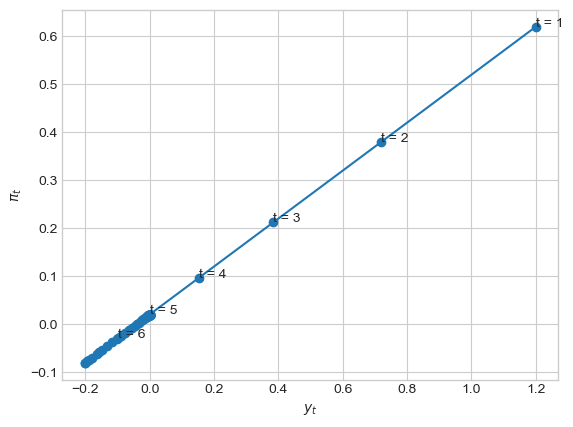

In [121]:
# your code here

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(sim['y'][1:],sim['pi'][1:],ls='-',marker='o')
ax.set_xlabel('$y_t$')
ax.set_ylabel('$\pi_t$');
for i in range(1,7):
    ax.text(sim['y'][i],sim['pi'][i]+0.0002,f't = {i}')

**Step 3 (continued):** Plot the simulated series for output and inflation **over time**

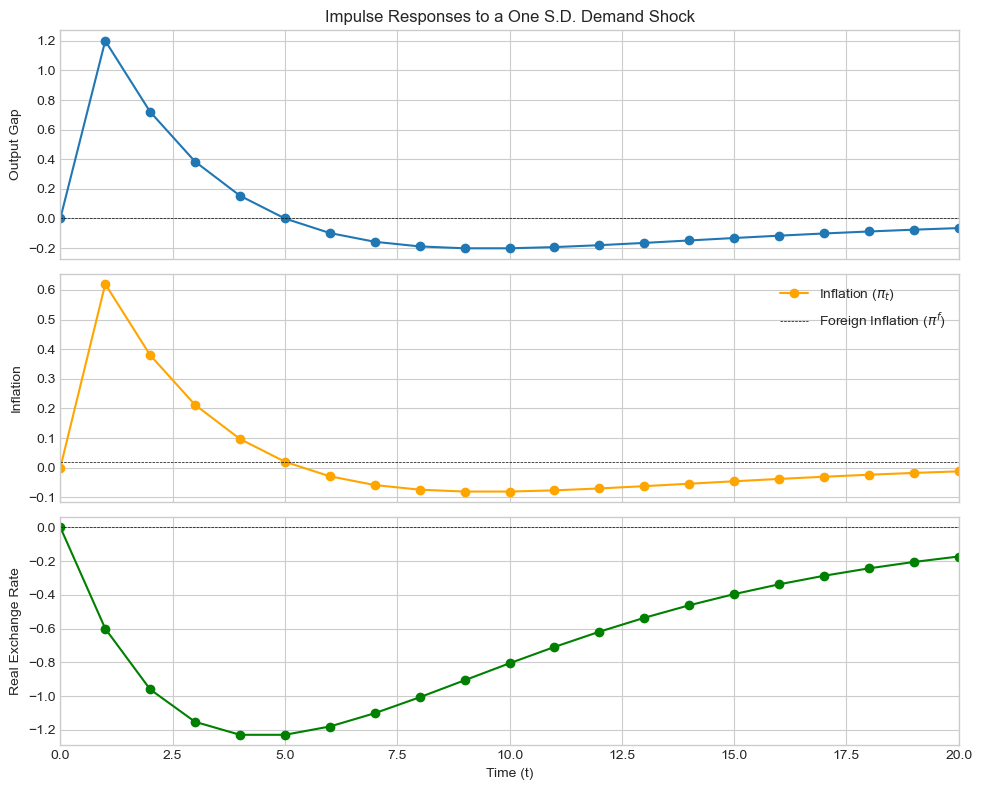

In [122]:
# your code here. Remember to plot inflation, the output gap, **and the real exchange rate**

# Create a figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plot Output Gap (y_t)
ax1.plot(sim['y'], marker='o', linestyle='-', label='Output Gap ($y_t$)')
ax1.set_ylabel('Output Gap')
ax1.set_title('Impulse Responses to a One S.D. Demand Shock')
ax1.grid(True)
ax1.axhline(0, color='black', lw=0.5, linestyle='--')
ax1.set_xlim(0, 20) # Limit x-axis to see adjustment clearly

# Plot Inflation (pi_t)
ax2.plot(sim['pi'], marker='o', linestyle='-', color='orange', label='Inflation ($\pi_t$)')
ax2.set_ylabel('Inflation')
ax2.grid(True)
ax2.axhline(par['pif'], color='black', lw=0.5, linestyle='--', label=f"Foreign Inflation ($\pi^f$)")
ax2.legend()

# Plot Real Exchange Rate (er_t)
ax3.plot(sim['er'], marker='o', linestyle='-', color='green', label='Real Exchange Rate ($e^r_t$)')
ax3.set_ylabel('Real Exchange Rate')
ax3.set_xlabel('Time (t)')
ax3.grid(True)
ax3.axhline(0, color='black', lw=0.5, linestyle='--')

plt.tight_layout()
plt.show()


[Your explanation here]

## 5. Simulating the model and calculating business cycle statistics (30%)

Continue to make the same assumptions about the shock processes as in the last question. Now instead of computing impulse responses (a one-time shock) simulate the AS-AD model for 100 periods (drawing a realization of $x_t$ and $c_t$ each of these periods). Plot the resulting time series and calculate the following statistics using ``std`` and ``corrcoef`` from ``numpy``:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$ 
3. Variance of $e^r_t$, $var(e^r_t)$ 
4. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
5. Correlation between $y_t$ and $e^r_t$, $corr(y_t,e^r_t)$
6. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
7. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

Explain the magnitude of 4.: Are output and inflation perfectly (negatively?) correlated? Why (not)? You might want to repeat the previous two questions for a supply shock to help you answer this. 

In [123]:
# your code here     
var_y = np.var(sim['y'])
var_pi = np.var(sim['pi'])
var_er = np.var(sim['er'])
corr_y_pi = np.corrcoef(sim['y'], sim['pi'])[0,1]
corr_y_er = np.corrcoef(sim['y'], sim['er'])[0,1]
autocorr_y = np.corrcoef(sim['y'][1:], sim['y'][:-1])[0,1]
autocorr_pi = np.corrcoef(sim['pi'][1:], sim['pi'][:-1])[0,1]

print(f"Variance of y_t: {var_y:.4f}")
print(f"Variance of pi_t: {var_pi:.4f}")
print(f"Variance of e^r_t: {var_er:.4f}")
print(f"Correlation between y_t and pi_t: {corr_y_pi:.4f}")
print(f"Correlation between y_t and e^r_t: {corr_y_er:.4f}")
print(f"Autocorrelation of y_t: {autocorr_y:.4f}")
print(f"Autocorrelation of pi_t: {autocorr_pi:.4f}")

Variance of y_t: 0.0247
Variance of pi_t: 0.0062
Variance of e^r_t: 0.1040
Correlation between y_t and pi_t: 0.9997
Correlation between y_t and e^r_t: -0.1218
Autocorrelation of y_t: 0.6200
Autocorrelation of pi_t: 0.6004


[Your explanation here]

<br>

## 6. Calibration (10%)

Last time we calibrated a single parameter. Now let's choose two empirical moments and pick values for two parameters of the model to match them. Specifically, based on simulations of T=1000 periods each, choose values for the volatility of the shocks, $\sigma_x$ and $\sigma_c$, to match the volatility of inflation and the output gap. 

Assume we want to match Denmark's empirical standard deviation of the output gap (1.59) and inflation (0.43). (Note that this is based on quarterly data, but even if you chose your other parameters based on annual data, let's stick with these numbers here for the purposes of this exercise.)

For each of the variables, plot how they change with the variance of the shocks. This might be best done with a contour plot. Based on the plot, choose values for $\sigma_c$ and $\sigma_x$ that ensure that $var(y_t)=1.6$ and $var(\pi_t)=0.5$, approximately. My plot looks something like this: https://drive.google.com/file/d/1so71vr12auY_99UYYmEi8H9n3xBD0E04/view?usp=sharing

You can then use a numerical optimizer or root finder to choose the parameters such that the simulated moments come close to the empirical values. Use your plots to choose good starting points to make sure the solver finds the desired optimum. Last time we used np.optimize_scalar, now we'll have to use np.optimize since we are optimizing over multiple variables rather than a scalar.

**The initial plot:**

In [124]:
T = 100
sim = prep_sim(par,T,None) # re-run this for current T and set seed==None so you get a new set of draws

# your code here


In [125]:
# your plots here
# use contourf and colorbar

**The optimization:**

In [126]:
# your code here